http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [30]:
from __future__ import print_function, division

import first
import nsfg
import hypothesis
import thinkstats2
import numpy as np
import pandas as pd
import scatter
import brfss
import thinkplot
%matplotlib inline

## Exercise 9.1

As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [31]:
live, firsts, others = first.MakeFrames()

In [32]:
def RunTests(live, iters=1000):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = hypothesis.CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [34]:
n = len(live)
for i in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

9148	0.17	0.00	0.00	0.00
4574	0.28	0.00	0.00	0.00
2287	0.27	0.07	0.00	0.00
1143	0.35	0.94	0.29	0.00
571	0.34	0.90	0.10	0.01
285	1.00	0.00	0.00	0.12
142	0.79	0.77	0.94	0.97


    Positive tests with large samples will decline the more data fades away.

## Exercise 10.1

Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [54]:
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [55]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163918066, 0.005281454169417841)

Make a scatter plot of the data and show the fitted line.

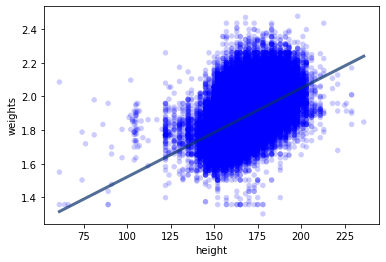

In [56]:
thinkplot.Scatter(heights, log_weights)
x, y = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(x, y)
thinkplot.Config(xlabel='height', ylabel='weights', legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

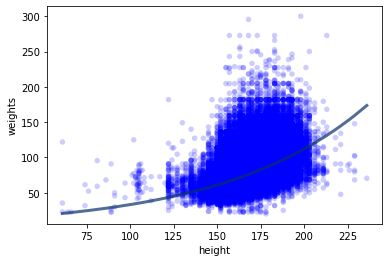

In [58]:
thinkplot.Scatter(heights, 10**log_weights)
x, y = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(x, 10**y)
thinkplot.Config(xlabel='height', ylabel='weights', legend=False)

Plot percentiles of the residuals.

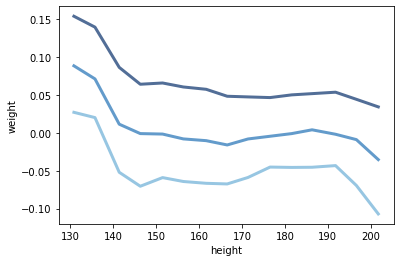

In [59]:
resid = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = resid

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height', ylabel='weight', legend=False)

Compute correlation.

In [60]:
corr1 = thinkstats2.Corr(heights, log_weights)
corr1

0.5317282605983464

Compute coefficient of determination.

In [62]:
cod1 = thinkstats2.CoefDetermination(log_weights, resid)
cod1

0.28273494311893543

Confirm that $R^2 = \rho^2$.

In [64]:
corr1**2 - cod1

7.605027718682322e-15

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [65]:
std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004854

Compute Std(res), the RMSE of predictions that do use height.

In [67]:
std_resid = thinkstats2.Std(resid)
std_resid

0.08740777080416082

How much does height information reduce RMSE? About 15%.

In [68]:
1 - std_res / std_ys

0.15308497658793152

Use resampling to compute sampling distributions for inter and slope.

In [69]:
t = []
for i in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

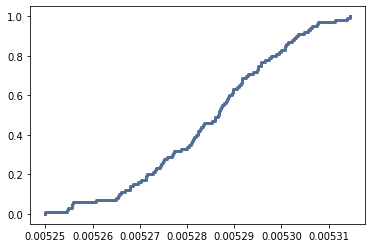

In [70]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [71]:
pvalue = cdf[0]
pvalue

0

Compute the 90% confidence interval of slope.

In [72]:
ci_90 = cdf.Percentile(5), cdf.Percentile(95)
ci_90

(0.005255651982892288, 0.00530648725548136)

Compute the mean of the sampling distribution.

In [73]:
mean = thinkstats2.Mean(slopes)
mean

0.00528493409666425

Compute the standard deviation of the sampling distribution, which is the standard error.

In [74]:
std_error = thinkstats2.Std(slopes)
std_error

1.449107378278443e-05

Resample rows without weights, compute mean height, and summarize results.

In [78]:
est_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for i in range(100)]
mean_unw = thinkstats2.Mean(est_unweighted)
std_error_unw = thinkstats2.Std(est_unweighted)
cdf_unw = thinkstats2.Cdf(est_unweighted)
ci_unw = cdf_unw.Percentile(5), cdf_unw.Percentile(95)

print('Mean_Unweighted', mean_unw)
print('Standard Error_Unweighted', std_error_unw)
print('Ci_Unweighted', ci_unw)

Mean_Unweighted 168.9569441581277
Standard Error_Unweighted 0.016153554748167858
Ci_Unweighted (168.9308014511207, 168.9807721457588)


In [79]:
def ResampleRowsWeighted(df, column='finalwt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [82]:
est_weighted = [ResampleRowsWeighted(df).htm3.mean() for _ in range(100)]
mean_w = thinkstats2.Mean(est_weighted)
std_error_w = thinkstats2.Std(est_weighted)
cdf_w = thinkstats2.Cdf(est_weighted)
ci_w = cdf_w.Percentile(5), cdf_w.Percentile(95)

print('Mean_weighted', mean_w)
print('Standard Error_weighted', std_error_w)
print('Ci_weighted', ci_w)

Mean_weighted 170.49352960346815
Standard Error_weighted 0.01528306802972357
Ci_weighted (170.46996705673115, 170.5148800501223)
